In [178]:
import matplotlib.pyplot as plt
import numpy as np
from fit_tools import *
from deproject_vis import deproject_vis
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
import scipy
from scipy.stats import gaussian_kde

In [171]:
## define data and directories

incl, PA = 36.5, 147.5

# location of visibilities
visdir = '/Users/calebpainter/Downloads/Research/THESIS/data/vis_stuff/iter_vis/'

# location of posteriors subdirectory
postdir = '/Users/calebpainter/Downloads/Research/THESIS/codes/outputs/'
plotdir = '/Users/calebpainter/Downloads/Research/THESIS/plots/vis/'

## define data

targ = 'MWC480'
cals = ['0','1','1f','2','3']

bands = ['A','U','Q','K','X']
lims = [((-1000,4000),(-2000,2500)),((-500,2000),(-1000,1200)),((-2500,6000),(-3000,4000)),((-2500,2000),(-2000,2000)),((-1000,1500),-1200,1200)]

disks = ['_Q.contp0', '_Q.contp1', 
        '_A.contp0', '_A.contp1', '_A.contp2', '_A.contp3',
        '_K.contp0', '_K.contp1', '_K.contp2', '_K.contp3',
        '_U.contp0', '_U.contp1', '_U.contp2', '_U.contp3',
        '_X.contp0-peeled', '_X.contp1-peeled', '_X.contp2-peeled', '_X.contp3-peeled',
        '_C.contp0', '_C.contp1', '_C.contp2', '_C.contp3',
        '_C.contp1f', '_C.contp1f', '_C.contp1f', '_C.contp1f']


In [172]:
## define classes
class Visibility:
            def __init__(self, vis, u, v, wgt):
                self.vis = vis
                self.u = u
                self.v = v
                self.wgt = wgt

## load visibilities
def load_data(band, cal):
    calib = cals[cal]
    if band == 'X':
         calib += '-peeled'
    _ = np.load(visdir+targ+'_'+band+'.'+f'contp{calib}.vis.npz')
    return  (_['Vis'], _['u'], _['v'], _['Wgt'])


## load posteriors
def load_posteriors(band, cal,model_type):
    calib = cals[cal]
    if band == 'X':
         calib += '-peeled'
    _ = np.load(postdir+targ+'_'+band+'.'+f'contp{calib}.{model_type}.post.npz')
    return  _

def plot_model(band_num,cal,model_type, ax):
    band = bands[band_num]
    
    vis_data = load_data(band, cal)
    posteriors = load_posteriors(band,cal,model_type)
    samples = posteriors['chain']
    samples[:,0] *= 1e6

    # fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5.5, 7.5), 
    #                 constrained_layout=True,
    #                 gridspec_kw={'height_ratios':[2, 1], 'hspace':0.10})

    duv = 2
    uvbins = np.arange(1, 125, duv)
    clevs = [15.85, 50., 84.15]
    CI = np.percentile(samples, clevs, axis=0)

    # actual data deprojected
    vp = deproject_vis(Visibility(vis_data[0], vis_data[1], vis_data[2], vis_data[3]), uvbins, incl=incl, PA=PA,
                            offx=CI[1,1], offy=CI[1,2])
    

    # plot posteriors
    ndraws = 30
    # drawing random values from the samples chain to plot many paths
    rix = np.random.randint(0, samples.shape[0], ndraws)
    for j in tqdm(range(ndraws)):
        if model_type == 'point':
            mdraw = ptsrc_model(samples[rix[j],:], vis_data[1], vis_data[2])
        if model_type == 'gaussian': 
            mdraw = gaussian_model(samples[rix[j],:], vis_data[1], vis_data[2])

        mvp = deproject_vis(Visibility(mdraw, vis_data[1], vis_data[2], vis_data[3]), uvbins, incl=incl, PA=PA,
                                offx=CI[1,1], offy=CI[1,2])
        ax[0].plot(1e-3*mvp.rho_uv, mvp.vis_prof.real, '-C1', alpha=0.1)
        ax[1].plot(1e-3*mvp.rho_uv, mvp.vis_prof.imag, '-C1', alpha=0.1)

    ax[0].axhline(y=0, linestyle=':', color='darkslategray')
    ax[0].errorbar(1e-3 * vp.rho_uv, 1e6 * vp.vis_prof.real, 
                yerr=1e6 * vp.err_std.real, fmt='o', color='k', zorder=0)
    ax[0].set_xlim([0, 1.1*uvbins.max()])
    ax[0].set_ylim([-0.1*1e6*vp.vis_prof.real.max(), 
                    1.25*1e6*vp.vis_prof.real.max()])
    ax[0].set_ylabel('real visibilities (uJy)')
    ax[0].set_xlabel('deprojected baseline length (k_lambda)')

    ax[1].axhline(y=0, linestyle=':', color='darkslategray')
    ax[1].errorbar(1e-3 * vp.rho_uv, 1e6 * vp.vis_prof.imag, 
                yerr=1e6 * vp.err_std.imag, fmt='o', color='k', zorder=0)
    ax[1].set_xlim([0, 1.1*uvbins.max()])
    ax[1].set_ylim([-1.25*1e6*vp.vis_prof.imag.max(),
                    1.25*1e6*vp.vis_prof.imag.max()])
    ax[1].set_ylabel('imag visibilities (uJy)')
    ax[1].set_xlabel('deprojected baseline length (k_lambda)')

    ax[0].set_ylim(lims[band_num][0][0],lims[band_num][0][1])
    ax[0].set_xlim(0,np.max(1e-3*mvp.rho_uv)+10)

    ax[1].set_ylim(lims[band_num][1][0],lims[band_num][1][1])
    ax[1].set_xlim(0,np.max(1e-3*mvp.rho_uv)+10)

    ax[0].set_title(f'Cal: {cals[cal]}')

In [189]:
posteriors = load_posteriors('A',1, 'point')
chain = posteriors['chain']

In [190]:
chain[:,0]

array([0.00074282, 0.00073668, 0.00074964, ..., 0.00074407, 0.00074649,
       0.00074063])

Band:  X


FileNotFoundError: [Errno 2] No such file or directory: '/Users/calebpainter/Downloads/Research/THESIS/codes/outputs/MWC480_X.contp0-peeled.gaussian.post.npz'

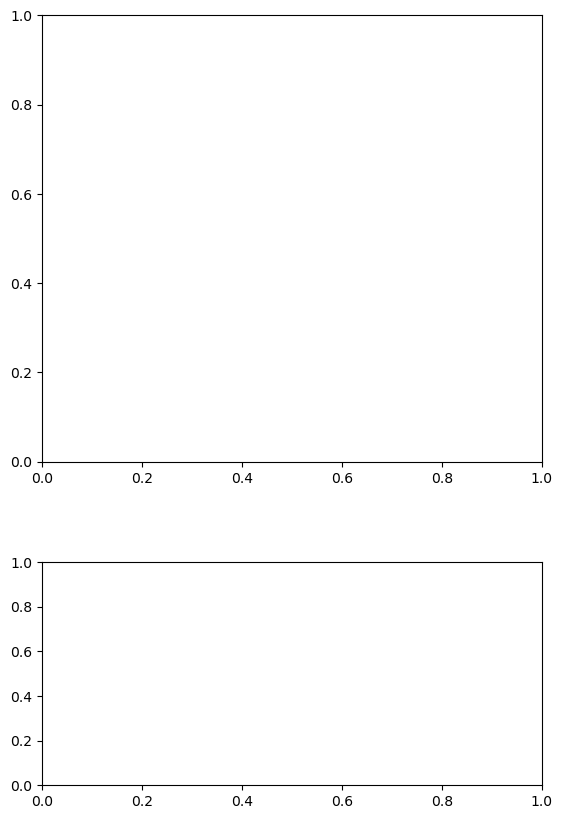

In [227]:
band_num = 4
band = bands[band_num]
model_type = 'gaussian'

fig = plt.figure(figsize=(40, 10))
gs = GridSpec(2, 5, figure=fig, height_ratios=[2, 1], hspace=0.3, wspace=0.3)

# Loop through 5 panels (columns in the GridSpec) and pass appropriate axes to plot_model
for cal in range(5):
    ax_real = fig.add_subplot(gs[0, cal])  # Top row for real part
    ax_imag = fig.add_subplot(gs[1, cal])  # Bottom row for imaginary part
    plot_model(band_num,cal,model_type, (ax_real, ax_imag))  # You can replace 'point' with 'gaussian' if needed

fig.suptitle(f'Band {band}')
plt.savefig(f'/Users/calebpainter/Downloads/Research/THESIS/plots/Band_{band}_{model_type}_calibrations.png')

In [217]:
def plot_posteriors(band_num, model_type):
    band = bands[band_num]

    ndim = 3
    fig, axs = plt.subplots(3,1,figsize=(20,20))
    params= ['flux [uJy]','dx ["]','dy ["]']

    if model_type == 'gaussian':
        ndim = 6 
        fig, axs = plt.subplots(2,3,figsize=(20,20))


    
    for cal in range(5):
        
        posteriors = load_posteriors(band,cal,model_type)
        samples = posteriors['chain']

        for param in range(ndim):
            data = samples[:,param]
            if param == 0:
                 data *= 1e6
            kde = gaussian_kde(data)
            x_vals = np.linspace(min(data), max(data), 1000)
            kde_vals = kde(x_vals)
            axs.flat[param].plot(x_vals, kde_vals,zorder=2,label=cals[cal])
            axs.flat[param].fill_between(x_vals, kde_vals, alpha=0.4,zorder=2)
            axs.flat[param].set_title(params[param])

            axs.flat[param].set_ylabel('Density')

            axs.flat[param].legend()

    plt.suptitle(f'Band: {band}')
    plt.savefig(f'/Users/calebpainter/Downloads/Research/THESIS/plots/Band_{band}_{model_type}_posterior_distributions.png')

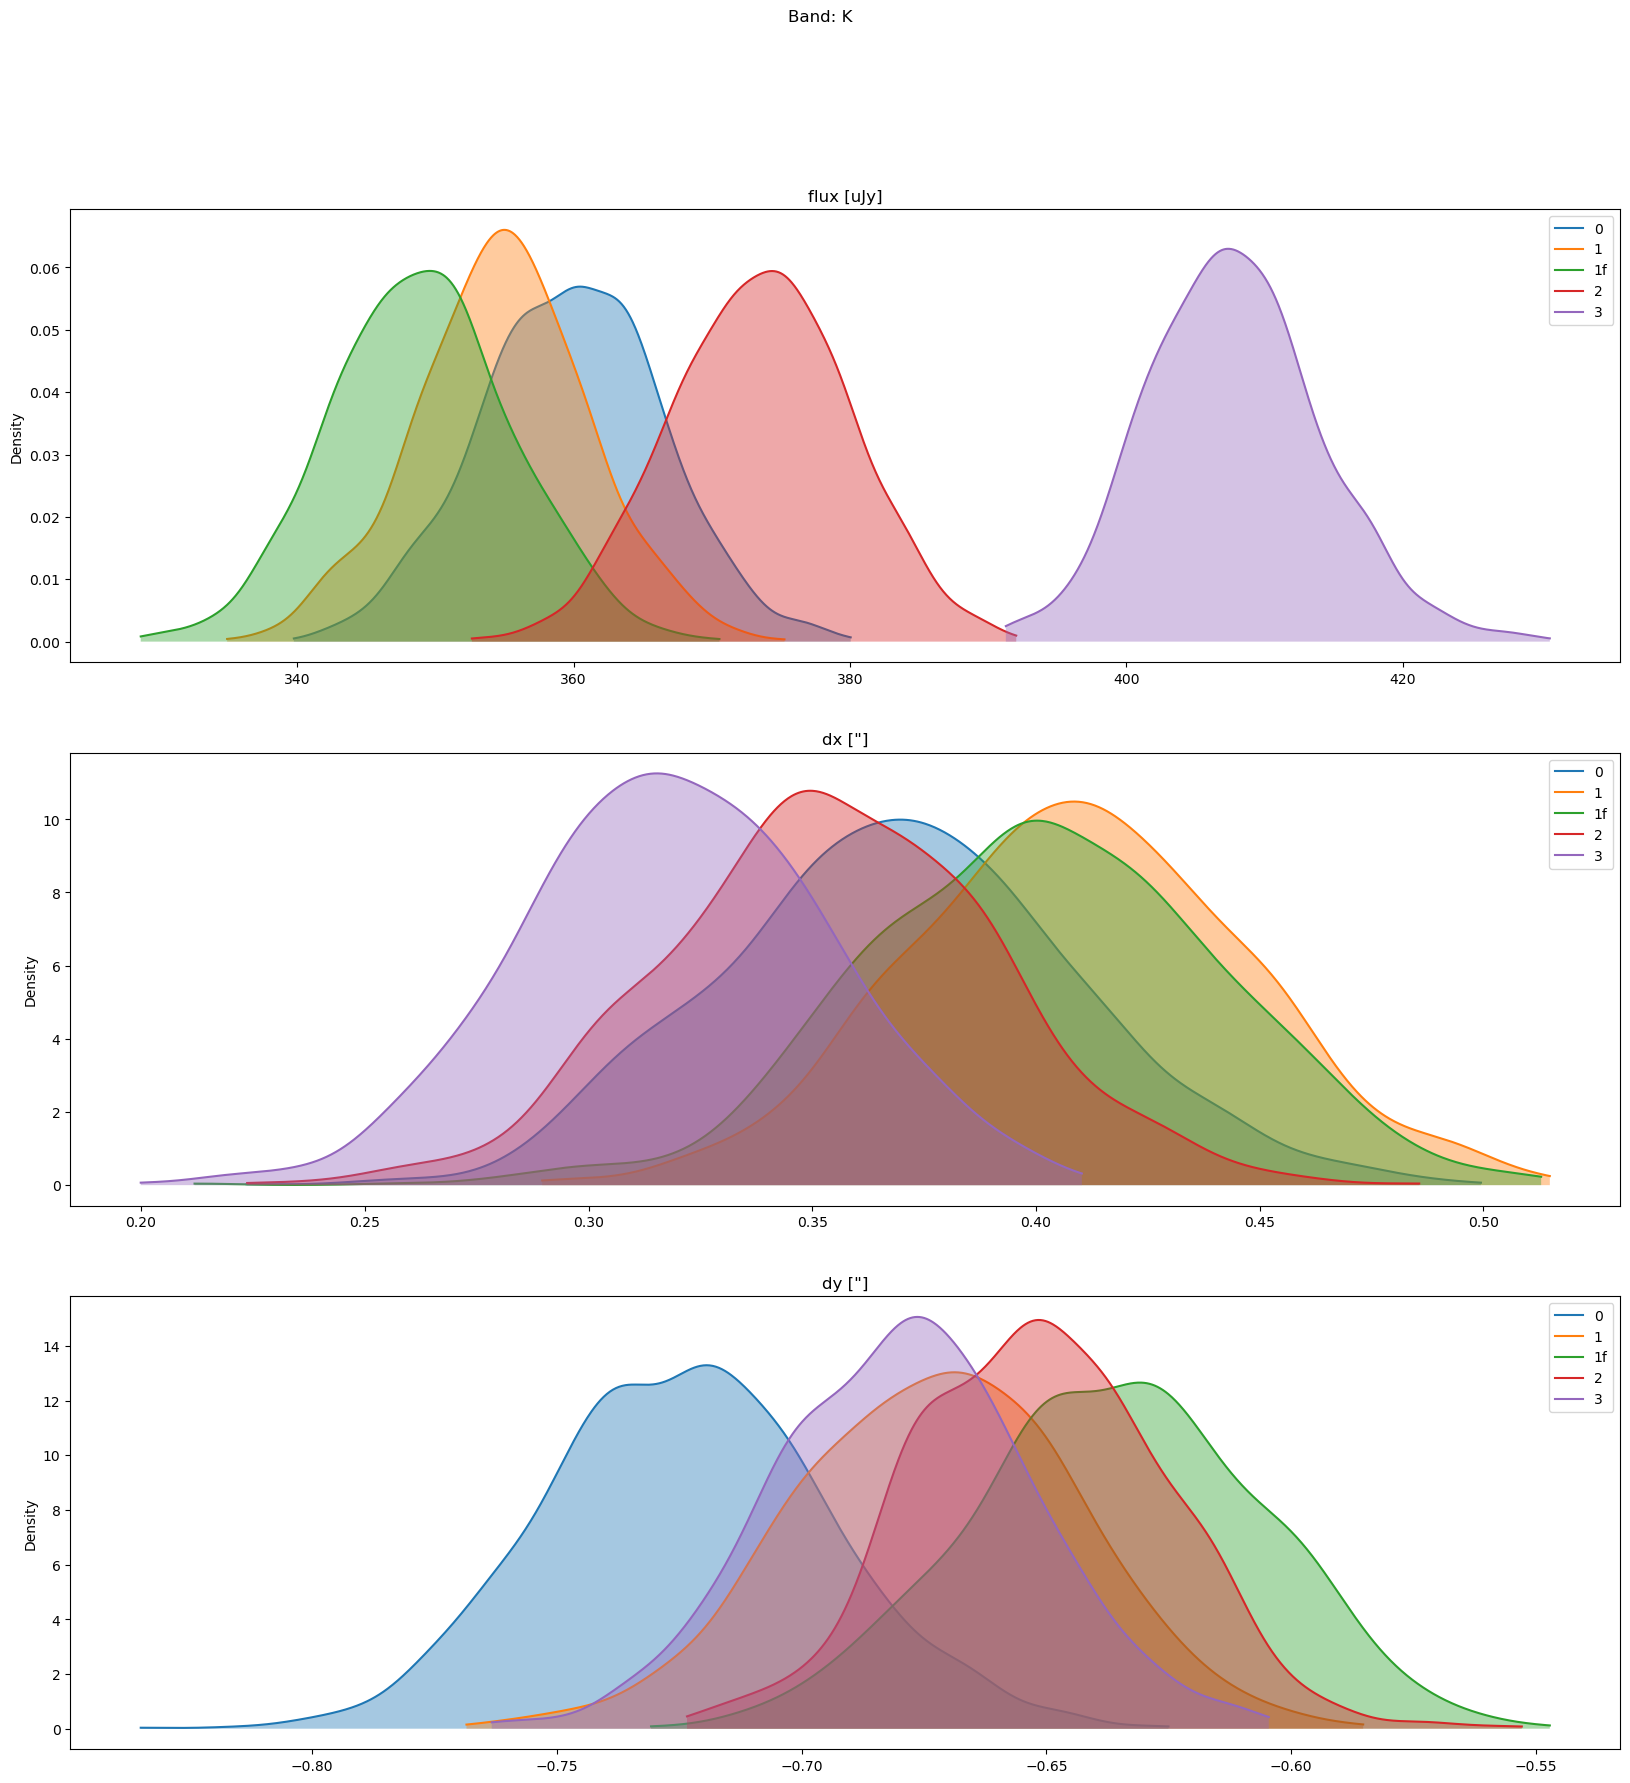

In [229]:
plot_posteriors(3,'point')

In [255]:
x=  np.random.chisquare(1000,size=10000)
y =  np.random.normal(size=10000)

(array([  17.,  107.,  577., 1917., 3027., 2704., 1276.,  328.,   42.,
           5.]),
 array([-3.90259268, -3.08901011, -2.27542754, -1.46184497, -0.6482624 ,
         0.16532018,  0.97890275,  1.79248532,  2.60606789,  3.41965047,
         4.23323304]),
 <BarContainer object of 10 artists>)

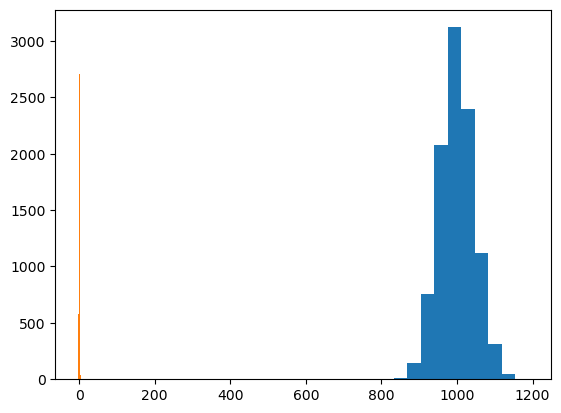

In [256]:
plt.hist(x)
plt.hist(y)

In [248]:
scipy.stats.kurtosis(x)

0.02931795403441484